# New approach

## Initial Data preparation (old)

In [1]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv("Genotyped.csv", index_col='index')
data

,wPt.0538,wPt.8463,wPt.6348,wPt.9992,wPt.2838,wPt.8266,wPt.1100,wPt.0653,wPt.4418,wPt.2152,...,c.408290,c.408294,c.408330,c.408336,c.408375,c.408393,c.408422,c.408424,c.408426,c.408443
index,,,,,,,,,,,,,,,,,,,,,
0,0,1,1,1,1,0,1,1,1,1,...,1,0,1,1,1,0,0,0,0,1
1,1,1,1,1,1,0,1,1,0,1,...,1,1,0,0,0,0,1,1,1,1
2,1,1,1,1,1,0,1,1,0,1,...,1,1,0,0,0,0,1,1,1,1
3,0,1,1,1,1,0,1,1,1,1,...,1,1,1,1,0,0,1,0,1,0
4,0,1,1,1,1,0,1,1,1,1,...,1,1,1,1,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,1,1,1,1,1,0,1,1,0,1,...,1,0,0,1,0,0,1,0,1,1
595,0,1,1,1,1,0,1,1,1,1,...,1,0,1,1,0,0,0,1,0,1
596,0,1,1,1,1,1,1,1,1,1,...,1,0,1,1,0,0,1,1,1,1


In [3]:
output = pd.read_csv("Phenotypes.csv", index_col="index")
output

,V1,V2,V3,V4,average phenotypes
index,,,,,
0,1.671629,-1.727470,-1.890285,0.050916,-0.648708
1,-0.252703,0.409522,0.309386,-1.738759,0.155402
2,0.341815,-0.648626,-0.799559,-1.053569,-0.368790
3,0.785439,0.093949,0.570468,0.551757,0.483285
4,0.998318,-0.282481,1.618682,-0.114285,0.778173
...,...,...,...,...,...
594,-1.248504,1.419042,1.574549,1.659656,0.581695
595,-1.052126,0.082785,2.138355,0.554385,0.389671
596,-1.209974,0.451963,2.022570,1.848717,0.421519


In [4]:
X = data
y = output.iloc[:,-1]

## Clustering (new)

In [6]:
from sklearn.cluster import KMeans
clustering = KMeans(n_clusters=2, random_state=0).fit(X)


In [17]:
colors = []

for x in clustering.labels_:
    if x == 0:
        colors.append("blue")
    else:
        colors.append("yellow")

pca = PCA(n_components=3)
pca.fit(X)
X_pca = pca.transform(X)


## Data visualization

<IPython.core.display.Javascript object>


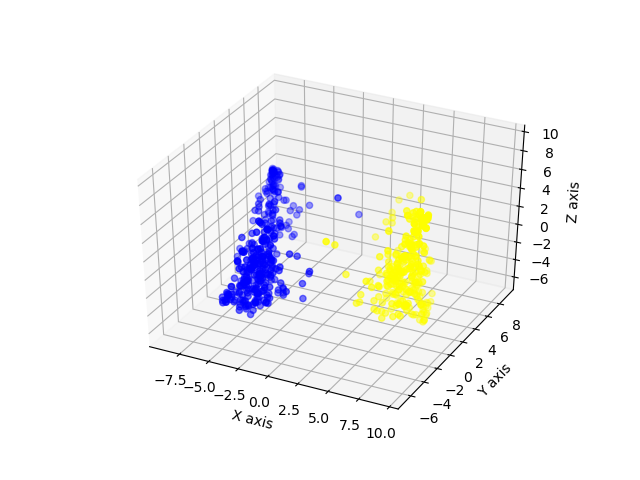

In [19]:
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib notebook

from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d

fig = plt.figure()
ax= plt.axes(projection='3d')

ax.scatter3D(X_pca[:, 0], X_pca[:, 1], X_pca[:,2], c=colors)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.show()


## Data split

In [39]:
X_one = X[clustering.labels_ == 0]
y_one = y[clustering.labels_ == 0]
X_two = X[clustering.labels_ == 1]
y_two = y[clustering.labels_ == 1]

## Training the model

### Training X_one

In [40]:
from sklearn.model_selection import train_test_split

split = 0.2 # use 20% of the data for testing.
X_one_train, X_one_test, y_one_train, y_one_test = train_test_split(X_one, y_one, test_size=split, random_state=42)

In [42]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

classifier = XGBRegressor(objective ='reg:squarederror')
grid = {
    'n_estimators': [200, 300],
    'max_depth' : [4, 5],
    'learning_rate' : [0.01, 0.001]
}

gd_sr = GridSearchCV(estimator=classifier,
                       param_grid=grid,
                       scoring='r2', # note the use of scoring here.
                       cv=5, iid=False)


gd_sr.fit(X_one_train, y_one_train)

best_parameters_one = gd_sr.best_params_
print(best_parameters_one)

{'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300}


In [43]:
best_clf_one = XGBRegressor(objective='reg:squarederror',
                        n_estimators=best_parameters_one['n_estimators'], 
                        max_depth=best_parameters_one['max_depth'], 
                        learning_rate=best_parameters_one['learning_rate'])

# has best set of parameters, now retrain on all training data.

best_clf_one.fit(X_one_train,y_one_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=None, n_estimators=300,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [45]:
y_one_pred = best_clf_one.predict(X_one_test)
y_one_pred_tr = best_clf_one.predict(X_one_train)

**Evaluation**

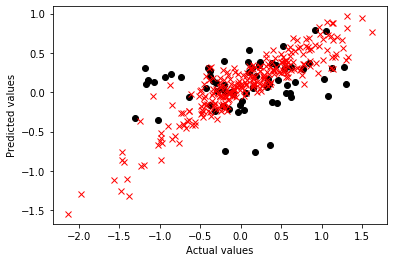

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.plot(y_one_test, y_one_pred, 'o', color='black')
plt.plot(y_one_train,y_one_pred_tr, 'x', color='red')
plt.show()

In [47]:
from sklearn.metrics import r2_score
# we use r2 because we are doing regression, not classification
print('Training set:',r2_score(y_one_train,y_one_pred_tr))
print('Test set:',r2_score(y_one_test,y_one_pred))

Training set: 0.7382960551725171
Test set: 0.010552840421237497


### Training X_two

In [48]:
split = 0.2 # use 20% of the data for testing.
X_two_train, X_two_test, y_two_train, y_two_test = train_test_split(X_two, y_two, test_size=split, random_state=42)

In [52]:
classifier = XGBRegressor(objective ='reg:squarederror')
grid = {
    'n_estimators': [200],
    'max_depth' : [1, 2],
    'learning_rate' : [0.01]
}

gd_sr = GridSearchCV(estimator=classifier,
                       param_grid=grid,
                       scoring='r2', # note the use of scoring here.
                       cv=5, iid=False)


gd_sr.fit(X_two_train, y_two_train)

best_parameters_two = gd_sr.best_params_
print(best_parameters_two)

{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 200}


In [53]:
best_clf_two = XGBRegressor(objective='reg:squarederror',
                        n_estimators=best_parameters_two['n_estimators'], 
                        max_depth=best_parameters_two['max_depth'], 
                        learning_rate=best_parameters_two['learning_rate'])

# has best set of parameters, now retrain on all training data.

best_clf_two.fit(X_two_train,y_two_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [54]:
y_two_pred = best_clf_two.predict(X_two_test)
y_two_pred_tr = best_clf_two.predict(X_two_train)

**Evaluation**

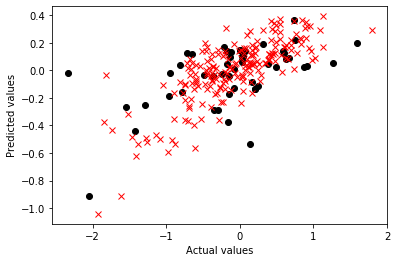

In [55]:
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.plot(y_two_test, y_two_pred, 'o', color='black')
plt.plot(y_two_train,y_two_pred_tr, 'x', color='red')
plt.show()

In [56]:
# we use r2 because we are doing regression, not classification
print('Training set:',r2_score(y_two_train,y_two_pred_tr))
print('Test set:',r2_score(y_two_test,y_two_pred))

Training set: 0.4170045594612857
Test set: 0.2170136805661711
